## Import & Process Image

In [1]:
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import glob

# from src.functions import preprocess_image, load_and_preprocess_image

AUTOTUNE = tf.data.experimental.AUTOTUNE ## tf.data transformation parameters

pd.options.display.max_columns = 100

## Data Cleaning

In [2]:
img_url = sorted(glob.glob('data/ISIC-images'+"/*.jpg"))
csv_names = [i for i in glob.glob('data'+'/*.csv')]
df = pd.read_csv('data/metadata.csv')

short=[]
for i in img_url:
    short.append(i[17:-4])
img_name = pd.Series(short,name='name')

df = pd.merge(df, img_name, on='name', how='inner')
df['image'] = img_url

df = df[['meta.clinical.diagnosis', 'image']]
df_na = df.copy()
df = df[df['meta.clinical.diagnosis'].notna()].reset_index(drop=True)
df.columns = ['diagnosis', 'image']
df['diagnosis'] = (df['diagnosis'] == 'melanoma').astype(int)

#### Deleted null values from dataset

In [3]:
df_na[df_na['meta.clinical.diagnosis'].isna()]

,meta.clinical.diagnosis,image
257,NaN,data/ISIC-images/ISIC_0000257.jpg
454,NaN,data/ISIC-images/ISIC_0000454.jpg
9892,NaN,data/ISIC-images/ISIC_0009892.jpg
9893,NaN,data/ISIC-images/ISIC_0009893.jpg
9924,NaN,data/ISIC-images/ISIC_0009924.jpg
...,...,...
13786,NaN,data/ISIC-images/ISIC_0024202.jpg
13787,NaN,data/ISIC-images/ISIC_0024203.jpg
13788,NaN,data/ISIC-images/ISIC_0024204.jpg
13789,NaN,data/ISIC-images/ISIC_0024205.jpg


##### df = All dataset

## EDA

In [4]:
diagnosis = df['diagnosis']

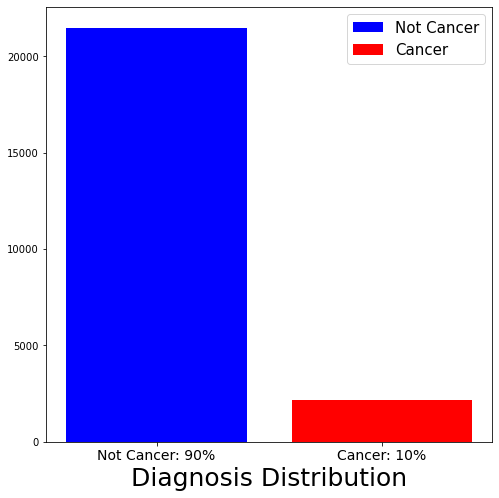

In [5]:
fig, ax = plt.subplots(figsize=(8,8))
xlabel = 25
xtick = 14
x0 = (diagnosis==0).sum()
x1 = (diagnosis==1).sum()

ax.set_xlabel('Diagnosis Distribution', size=xlabel)

ax.bar(0, x0, color = 'b', label='Not Cancer')
ax.bar(1, x1, color = 'r', label='Cancer')
ax.set_xticks([0,1])
ax.set_xticklabels(['Not Cancer: 90%', 'Cancer: 10%'], size=xtick)
plt.legend(prop={'size': 15})
plt.show()

## Pipeline

In [8]:
def preprocess_image(image, imgage_shape=[100,100]):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, imgage_shape)
    image /= 255.0  # normalize to [0,1] range
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def create_X_y(df):
    y = df['diagnosis']
    X = []
    for i in df['image']:
        image = load_and_preprocess_image(i)
        X.append(np.asarray(image))
    return np.asarray(X), np.asarray(y)

#### Creating Test Set and Save processed image set

In [27]:
# Code to create X and y.
# X, y = create_X_y(df)

In [24]:
# np.save('data/100x100.npy', X)

#### Train Test Split for Train, validation, test set

In [29]:
X = np.load('data/100x100.npy')
y = np.asarray(df['diagnosis'])

In [42]:
# Train/test split for Train Set
XX_train, X_test, yy_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(XX_train, yy_train, test_size=0.2, random_state=42, stratify=yy_train)

#### Train Model

In [77]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(100,100,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [78]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [69]:
zeros = (y_train==0).sum()
ones = (y_train==1).sum()

In [70]:
ones/ (ones+zeros)

0.09162978133051464

In [76]:
zeros/ (ones+zeros)

0.9083702186694854

In [79]:
class_weight = {1:0.9,
                0:0.1}

In [80]:
history = model.fit(X_train, y_train, epochs=10, class_weight=class_weight, validation_data=(X_test, y_test))

Epoch 1/10
474/474 [==============================] - 56s 117ms/step - loss: 0.1037 - accuracy: 0.5996 - val_loss: 0.6833 - val_accuracy: 0.4259
Epoch 2/10
474/474 [==============================] - 55s 115ms/step - loss: 0.0934 - accuracy: 0.5890 - val_loss: 0.3939 - val_accuracy: 0.7523
Epoch 3/10
474/474 [==============================] - 55s 116ms/step - loss: 0.0945 - accuracy: 0.6119 - val_loss: 0.4586 - val_accuracy: 0.7377
Epoch 4/10
474/474 [==============================] - 55s 115ms/step - loss: 0.0867 - accuracy: 0.5915 - val_loss: 0.4800 - val_accuracy: 0.6413
Epoch 5/10
474/474 [==============================] - 55s 115ms/step - loss: 0.0851 - accuracy: 0.5852 - val_loss: 0.3724 - val_accuracy: 0.8134
Epoch 6/10
474/474 [==============================] - 55s 115ms/step - loss: 0.0862 - accuracy: 0.5962 - val_loss: 0.5375 - val_accuracy: 0.6426
Epoch 7/10
474/474 [==============================] - 55s 115ms/step - loss: 0.0814 - accuracy: 0.6571 - val_loss: 0.5591 - val_ac

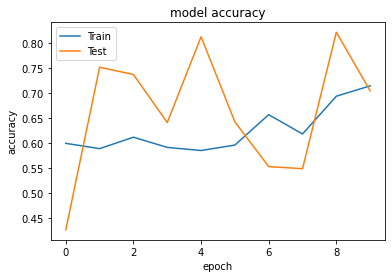

In [81]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

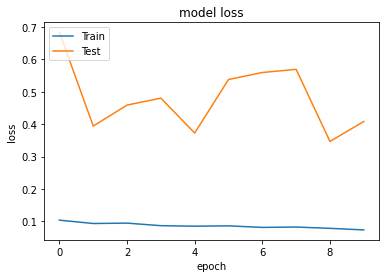

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
activation_15 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
activation_16 (Activation)   (None, 47, 47, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 64)       

## Evalaution

In [84]:
def matrix_score(y_test, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print(np.array([[tp, fn],[fp, tn]]))
    print('Recall:    {:.2f}'.format(tp/(tp+fn)))
    print('Precision: {:.2f}'.format(tp/(tp+fp)))
    print('Accuracy:  {:.2f}'.format((tp+tn)/(tp+tn+fp+fn)))
    print('ROC AUC:   {:.2f}'.format(roc_auc_score(y_test, y_pred)))

In [85]:
# Validation Set
val_loss1, val_acc = model.evaluate(X_val, y_val, verbose=0)
print('Validation set accuracy {:5.2f}%'.format(100*val_acc))
# Test Set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Test set accuracy {:5.2f}%'.format(100*test_acc))

Validation set accuracy 71.78%
Test set accuracy 70.49%


In [93]:
threshold = 0.5

In [94]:
# Validation Set
result = (model.predict(X_val) > threshold).astype(int)
result =[i[0] for i in result]
y_val_pred = np.asarray(result)

matrix_score(y_val, y_val_pred)

[[ 305   42]
 [1026 2412]]
Recall:    0.88
Precision: 0.23
Accuracy:  0.72
ROC AUC:   0.79


In [95]:
# Test Set
result = (model.predict(X_test) > threshold).astype(int)
result =[i[0] for i in result]
y_test_pred = np.asarray(result)

matrix_score(y_test, y_test_pred)

[[ 382   52]
 [1344 2953]]
Recall:    0.88
Precision: 0.22
Accuracy:  0.70
ROC AUC:   0.78


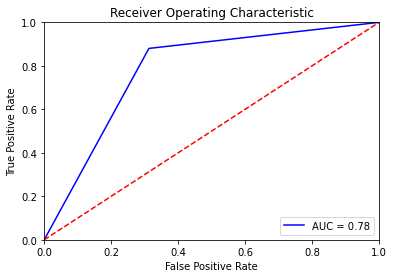

In [96]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()